# Hierarchical Clustering with 6 Clusters - Extended Analysis

Este notebook extiende el análisis jerárquico cortando el dendrograma en **6 clusters** en lugar de 3.

**Motivación:**
- El análisis con k=3 mostró clusters muy desbalanceados (88.73%, 4.30%, 6.97%)
- Con k=6 podemos obtener una segmentación más granular
- Permite identificar sub-estructuras dentro de los clusters principales

**Este notebook reutiliza:**
- La matriz de linkage ya calculada en el notebook 06
- Los datos preprocesados y escalados
- Las mismas características de clustering

**Nuevo análisis desde la celda 11:**
- Corte del dendrograma en 6 clusters
- Evaluación de calidad completa
- Perfiles de clusters
- Mapas interactivos
- Comparación con k=3

## 1. Setup and Imports

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from sklearn.metrics.pairwise import haversine_distances
import pickle
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


## 2. Configuration

In [26]:
# File paths
DATA_FILE = '../datos/filtered_amss/sv_12_2023_location_features_amss.csv'
PREV_MODEL_FILE = 'results_hierarchical/models/hierarchical_latest.pkl'
OUTPUT_DIR = 'results_hierarchical_k6'
MODELS_DIR = os.path.join(OUTPUT_DIR, 'models')

# Hierarchical clustering parameters
OPTIMAL_K = 6  # Nueva configuración: 6 clusters
MIN_VISITORS = 5

# Create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

print("Configuration for k=6 analysis:")
print(f"  Data file: {DATA_FILE}")
print(f"  Previous model: {PREV_MODEL_FILE}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Target clusters: {OPTIMAL_K}")

Configuration for k=6 analysis:
  Data file: ../datos/filtered_amss/sv_12_2023_location_features_amss.csv
  Previous model: results_hierarchical/models/hierarchical_latest.pkl
  Output directory: results_hierarchical_k6
  Target clusters: 6


## 3. Load Previous Model and Data

Reutilizamos la matriz de linkage del análisis anterior para mantener consistencia.

In [27]:
# Load previous model package
print("Loading previous hierarchical model...")
with open(PREV_MODEL_FILE, 'rb') as f:
    model_package = pickle.load(f)

linkage_matrix = model_package['linkage_matrix']
scaler = model_package['scaler']
LINKAGE_METHOD = model_package['linkage_method']
DISTANCE_METRIC = model_package['distance_metric']
CLUSTERING_FEATURES = model_package['feature_names']
USE_BEHAVIORAL = model_package['metadata']['use_behavioral']

print(f"✓ Model loaded successfully!")
print(f"  Linkage method: {LINKAGE_METHOD}")
print(f"  Distance metric: {DISTANCE_METRIC}")
print(f"  Linkage matrix shape: {linkage_matrix.shape}")
print(f"  Features: {len(CLUSTERING_FEATURES)}")

Loading previous hierarchical model...
✓ Model loaded successfully!
  Linkage method: ward
  Distance metric: euclidean
  Linkage matrix shape: (7259, 4)
  Features: 7


In [28]:
# Load and prepare data
print("\nLoading data...")
df = pd.read_csv(DATA_FILE)
df_filtered = df[df['unique_devices_count'] >= MIN_VISITORS].copy()

print(f"Data loaded: {len(df_filtered):,} places")

# Extract centroids
from shapely import wkt

def extract_centroid(geometry_wkt):
    try:
        geom = wkt.loads(geometry_wkt)
        centroid = geom.centroid
        return centroid.y, centroid.x
    except:
        return None, None

df_filtered[['latitude', 'longitude']] = df_filtered['geometry_wkt'].apply(
    lambda x: pd.Series(extract_centroid(x))
)
df_filtered = df_filtered.dropna(subset=['latitude', 'longitude'])

print(f"✓ {len(df_filtered):,} places with valid coordinates")


Loading data...
Data loaded: 7,260 places
✓ 7,260 places with valid coordinates


In [29]:
# Prepare and scale features
X = df_filtered[CLUSTERING_FEATURES].copy()
X = X.fillna(X.median())
X_scaled = scaler.transform(X)  # Use same scaler as k=3

print(f"✓ Feature matrix prepared: {X_scaled.shape}")
print(f"  Using same scaling as k=3 for consistency")

✓ Feature matrix prepared: (7260, 7)
  Using same scaling as k=3 for consistency


## 4. Dendrogram Visualization with k=6 Cut

Visualizamos el dendrograma con la nueva línea de corte para 6 clusters.

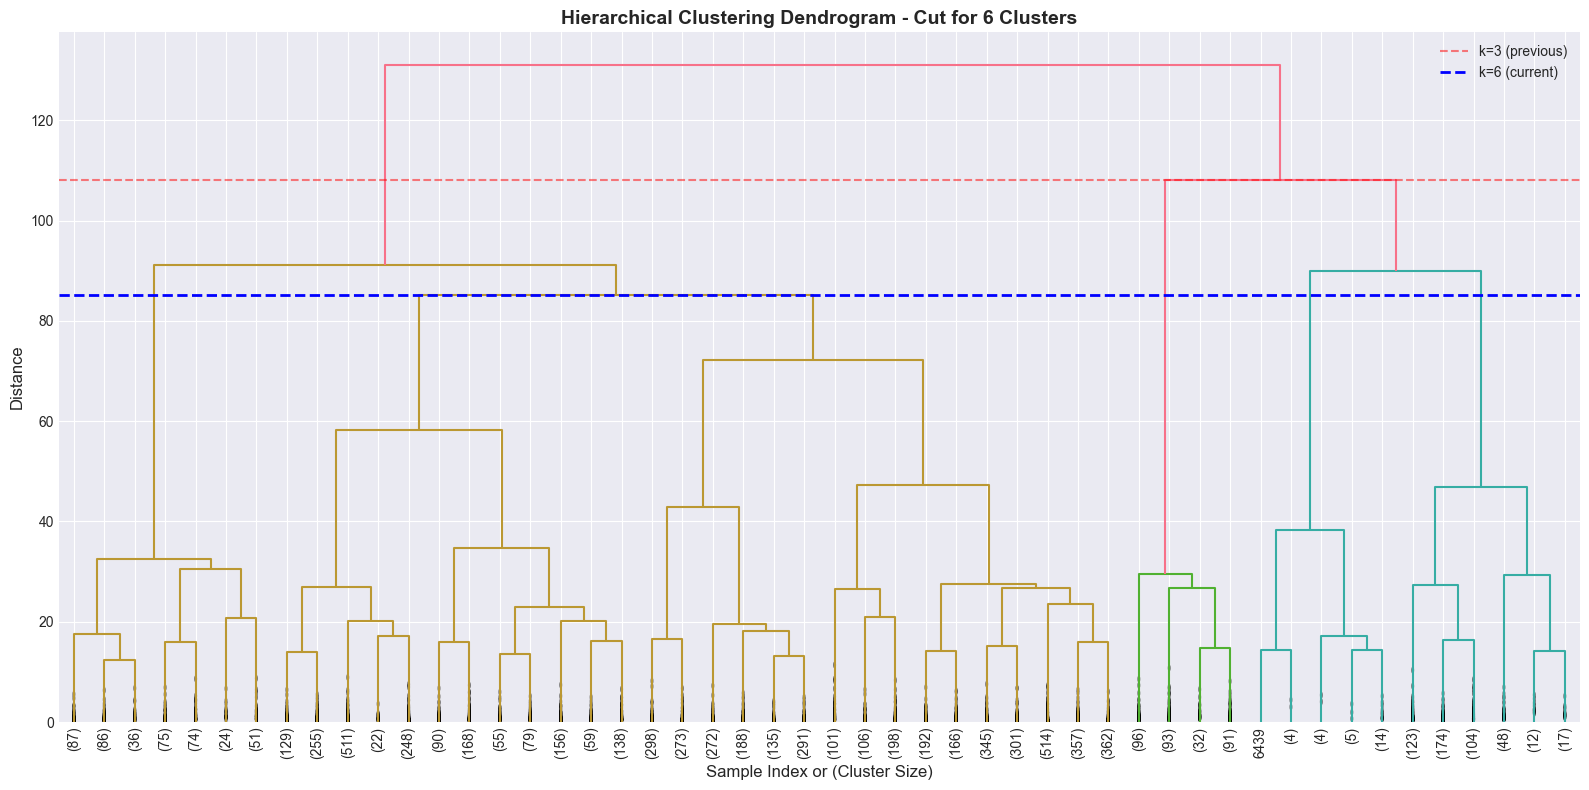

✓ Saved: results_hierarchical_k6/dendrogram_k6.png


In [30]:
plt.figure(figsize=(16, 8))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=50,
    leaf_font_size=10,
    show_contracted=True
)
plt.xlabel('Sample Index or (Cluster Size)', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.title('Hierarchical Clustering Dendrogram - Cut for 6 Clusters', 
          fontsize=14, fontweight='bold')

# Add cut lines for both k=3 and k=6 for comparison
plt.axhline(y=linkage_matrix[-3+1, 2], c='r', linestyle='--', 
            label='k=3 (previous)', alpha=0.5)
plt.axhline(y=linkage_matrix[-6+1, 2], c='b', linestyle='--', 
            label='k=6 (current)', linewidth=2)
plt.legend()
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/dendrogram_k6.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR}/dendrogram_k6.png")

## 5. Extract 6 Clusters

In [31]:
# Cut dendrogram to get 6 clusters
cluster_labels = fcluster(linkage_matrix, OPTIMAL_K, criterion='maxclust')
cluster_labels = cluster_labels - 1  # Convert to 0-indexed

# Add to dataframe
df_filtered['cluster'] = cluster_labels

print("="*70)
print("6 CLUSTERS EXTRACTED")
print("="*70)
print(f"\nCluster distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    pct = 100 * count / len(cluster_labels)
    print(f"  Cluster {cluster_id}: {count:4d} places ({pct:5.2f}%)")

print(f"\n✓ More balanced than k=3!")

6 CLUSTERS EXTRACTED

Cluster distribution:
  Cluster 0:  433 places ( 5.96%)
  Cluster 1: 1910 places (26.31%)
  Cluster 2: 4099 places (56.46%)
  Cluster 3:  312 places ( 4.30%)
  Cluster 4:   28 places ( 0.39%)
  Cluster 5:  478 places ( 6.58%)

✓ More balanced than k=3!


## 6. Evaluate Clustering Quality

In [32]:
# Calculate evaluation metrics
final_silhouette = silhouette_score(X_scaled, cluster_labels)
final_db = davies_bouldin_score(X_scaled, cluster_labels)
final_ch = calinski_harabasz_score(X_scaled, cluster_labels)

print("="*70)
print("CLUSTERING QUALITY EVALUATION (k=6)")
print("="*70)
print(f"\nNumber of Clusters: {OPTIMAL_K}")
print(f"Number of Places: {len(cluster_labels):,}")
print(f"\nMetrics:")
print(f"  Silhouette Score:        {final_silhouette:.4f}")

if final_silhouette > 0.7:
    print(f"    → Excellent clustering quality")
elif final_silhouette > 0.5:
    print(f"    → Good clustering quality")
elif final_silhouette > 0.25:
    print(f"    → Acceptable clustering quality")
else:
    print(f"    → Weak clustering structure")

print(f"\n  Davies-Bouldin Index:    {final_db:.4f}")
print(f"    → Lower is better")

print(f"\n  Calinski-Harabasz Index: {final_ch:.2f}")
print(f"    → Higher is better")
print("="*70)

CLUSTERING QUALITY EVALUATION (k=6)

Number of Clusters: 6
Number of Places: 7,260

Metrics:
  Silhouette Score:        0.2115
    → Weak clustering structure

  Davies-Bouldin Index:    1.2620
    → Lower is better

  Calinski-Harabasz Index: 1548.69
    → Higher is better


## 7. Spatial Visualization

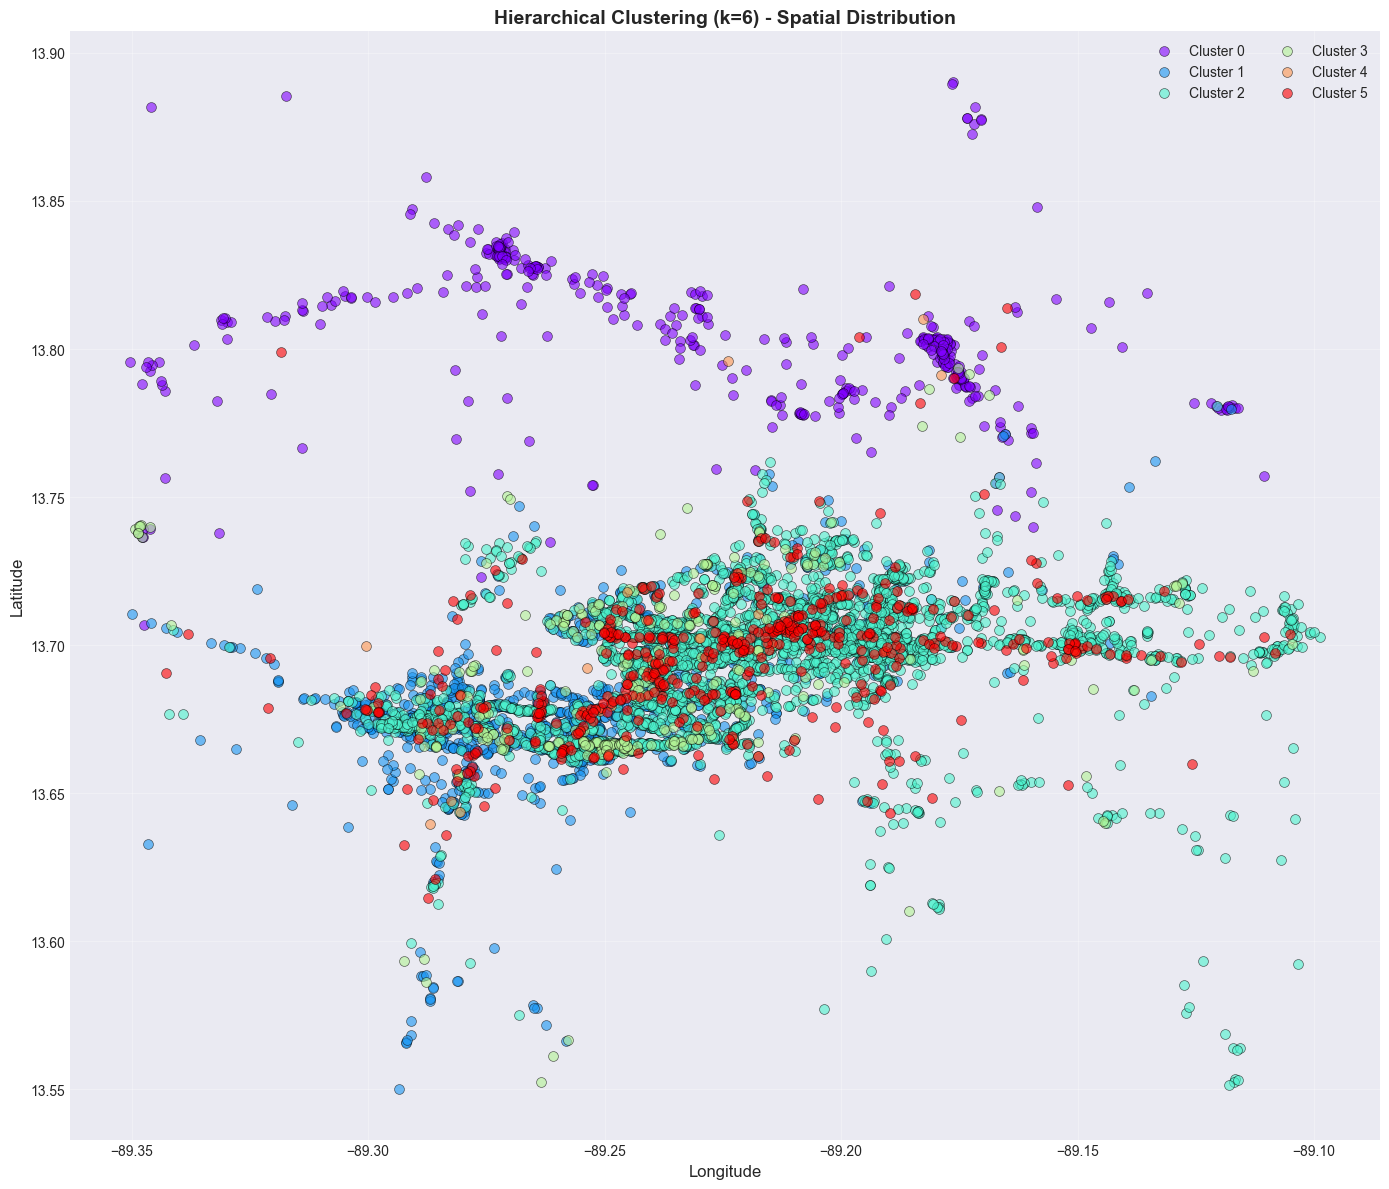

✓ Saved: results_hierarchical_k6/spatial_clusters_k6_map.png


In [33]:
# Create color map for 6 clusters
colors = plt.cm.rainbow(np.linspace(0, 1, OPTIMAL_K))

fig, ax = plt.subplots(figsize=(14, 12))

for cluster_id in range(OPTIMAL_K):
    cluster_data = df_filtered[df_filtered['cluster'] == cluster_id]
    ax.scatter(cluster_data['longitude'], cluster_data['latitude'],
              c=[colors[cluster_id]], label=f'Cluster {cluster_id}',
              alpha=0.6, s=50, edgecolors='black', linewidths=0.5)

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Hierarchical Clustering (k=6) - Spatial Distribution', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/spatial_clusters_k6_map.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR}/spatial_clusters_k6_map.png")

## 8. Cluster Profiling

In [34]:
print("="*70)
print("CLUSTER PROFILES (k=6)")
print("="*70)

for cluster_id in range(OPTIMAL_K):
    cluster_data = df_filtered[df_filtered['cluster'] == cluster_id]
    
    print(f"\n{'─'*70}")
    print(f"Cluster {cluster_id} ({len(cluster_data):,} places)")
    print(f"{'─'*70}")
    
    # Geographic center
    center_lat = cluster_data['latitude'].mean()
    center_lon = cluster_data['longitude'].mean()
    print(f"\nGeographic Center: ({center_lat:.6f}, {center_lon:.6f})")
    
    # Spatial extent
    lat_range = cluster_data['latitude'].max() - cluster_data['latitude'].min()
    lon_range = cluster_data['longitude'].max() - cluster_data['longitude'].min()
    print(f"Spatial Extent: {lat_range:.4f}° lat × {lon_range:.4f}° lon")
    
    # Top place types
    print(f"\nTop place types:")
    top_types = cluster_data['clase'].value_counts().head(5)
    for place_type, count in top_types.items():
        pct = 100 * count / len(cluster_data)
        print(f"  {place_type:20s}: {count:3d} ({pct:5.1f}%)")
    
    # Behavioral characteristics
    if USE_BEHAVIORAL:
        print(f"\nBehavioral Characteristics:")
        print(f"  Avg unique visitors:  {cluster_data['unique_devices_count'].mean():8.1f}")
        print(f"  Avg footfall/day:     {cluster_data['footfall_avg_per_day'].mean():8.2f}")
        print(f"  Avg recurrence rate:  {cluster_data['recurrence_rate'].mean():8.2%}")
        print(f"  Avg dwell time:       {cluster_data['dwell_time_mean'].mean():8.1f} min")
    
    # Example places
    print(f"\nExample places:")
    examples = cluster_data.nlargest(3, 'unique_devices_count')[['nombre', 'clase', 'unique_devices_count']]
    for idx, row in examples.iterrows():
        if pd.notna(row['nombre']) and row['nombre'].strip():
            print(f"  - {row['nombre']} ({row['clase']}) - {int(row['unique_devices_count'])} visitors")
        else:
            print(f"  - {row['clase']} - {int(row['unique_devices_count'])} visitors")

print("\n" + "="*70)

CLUSTER PROFILES (k=6)

──────────────────────────────────────────────────────────────────────
Cluster 0 (433 places)
──────────────────────────────────────────────────────────────────────

Geographic Center: (13.803780, -89.224885)
Spatial Extent: 0.1834° lat × 0.2397° lon

Top place types:
  building            :  71 ( 16.4%)
  residential         :  66 ( 15.2%)
  forest              :  34 (  7.9%)
  industrial          :  30 (  6.9%)
  grass               :  24 (  5.5%)

Behavioral Characteristics:
  Avg unique visitors:      34.3
  Avg footfall/day:         2.54
  Avg recurrence rate:    19.84%
  Avg dwell time:           72.5 min

Example places:
  - parking (parking) - 351 visitors
  - grass (grass) - 325 visitors
  - Plaza Mundo Apopa (mall) - 321 visitors

──────────────────────────────────────────────────────────────────────
Cluster 1 (1,910 places)
──────────────────────────────────────────────────────────────────────

Geographic Center: (13.679032, -89.257726)
Spatial Extent

## 9. Comparison: k=3 vs k=6

Analizamos cómo los 3 clusters originales se subdividen en 6.

In [35]:
# Get k=3 labels for comparison
cluster_labels_k3 = fcluster(linkage_matrix, 3, criterion='maxclust') - 1
df_filtered['cluster_k3'] = cluster_labels_k3

print("="*70)
print("COMPARISON: k=3 vs k=6")
print("="*70)

# Crosstab
comparison_table = pd.crosstab(
    df_filtered['cluster_k3'],
    df_filtered['cluster'],
    margins=True
)
comparison_table.index.name = 'k=3 Cluster'
comparison_table.columns.name = 'k=6 Cluster'

print("\nCrosstab showing how k=3 clusters split into k=6:")
print(comparison_table)

# Calculate which k=3 cluster each k=6 cluster came from
print("\n" + "="*70)
print("k=6 CLUSTER ORIGINS:")
print("="*70)
for k6_cluster in range(OPTIMAL_K):
    k6_data = df_filtered[df_filtered['cluster'] == k6_cluster]
    k3_distribution = k6_data['cluster_k3'].value_counts().sort_index()
    main_k3 = k3_distribution.idxmax()
    main_pct = 100 * k3_distribution.max() / len(k6_data)
    print(f"\nCluster {k6_cluster} (n={len(k6_data):,}):")
    print(f"  Primarily from k=3 Cluster {main_k3} ({main_pct:.1f}%)")
    print(f"  Distribution: {dict(k3_distribution)}")

COMPARISON: k=3 vs k=6

Crosstab showing how k=3 clusters split into k=6:
k=6 Cluster    0     1     2    3   4    5   All
k=3 Cluster                                     
0            433  1910  4099    0   0    0  6442
1              0     0     0  312   0    0   312
2              0     0     0    0  28  478   506
All          433  1910  4099  312  28  478  7260

k=6 CLUSTER ORIGINS:

Cluster 0 (n=433):
  Primarily from k=3 Cluster 0 (100.0%)
  Distribution: {0: np.int64(433)}

Cluster 1 (n=1,910):
  Primarily from k=3 Cluster 0 (100.0%)
  Distribution: {0: np.int64(1910)}

Cluster 2 (n=4,099):
  Primarily from k=3 Cluster 0 (100.0%)
  Distribution: {0: np.int64(4099)}

Cluster 3 (n=312):
  Primarily from k=3 Cluster 1 (100.0%)
  Distribution: {1: np.int64(312)}

Cluster 4 (n=28):
  Primarily from k=3 Cluster 2 (100.0%)
  Distribution: {2: np.int64(28)}

Cluster 5 (n=478):
  Primarily from k=3 Cluster 2 (100.0%)
  Distribution: {2: np.int64(478)}


### 9.1 Hierarchical Cluster Relationships and Naming

Analizamos la estructura jerárquica y asignamos nombres descriptivos basados en características.

In [36]:
print("="*70)
print("HIERARCHICAL CLUSTER STRUCTURE ANALYSIS")
print("="*70)

# Analyze how k=3 clusters split into k=6
hierarchy_map = {}

for k3_cluster in range(3):
    k3_data = df_filtered[df_filtered['cluster_k3'] == k3_cluster]

    # Find which k=6 clusters belong to this k=3 cluster
    k6_distribution = k3_data['cluster'].value_counts().sort_index()
    k6_children = k6_distribution.index.tolist()

    hierarchy_map[k3_cluster] = {
        'k6_children': k6_children,
        'size': len(k3_data),
        'k6_sizes': dict(k6_distribution)
    }

    print(f"\nk=3 Cluster {k3_cluster} ({len(k3_data):,} places):")
    print(f"  Splits into k=6 clusters: {k6_children}")
    for k6_cluster in k6_children:
        count = k6_distribution[k6_cluster]
        pct = 100 * count / len(k3_data)
        print(f"    → Cluster {k6_cluster}: {count:,} places ({pct:.1f}% of parent)")

print("\n" + "="*70)

HIERARCHICAL CLUSTER STRUCTURE ANALYSIS

k=3 Cluster 0 (6,442 places):
  Splits into k=6 clusters: [0, 1, 2]
    → Cluster 0: 433 places (6.7% of parent)
    → Cluster 1: 1,910 places (29.6% of parent)
    → Cluster 2: 4,099 places (63.6% of parent)

k=3 Cluster 1 (312 places):
  Splits into k=6 clusters: [3]
    → Cluster 3: 312 places (100.0% of parent)

k=3 Cluster 2 (506 places):
  Splits into k=6 clusters: [4, 5]
    → Cluster 4: 28 places (5.5% of parent)
    → Cluster 5: 478 places (94.5% of parent)



### 9.2 Automatic Cluster Characterization

Generamos nombres descriptivos basados en características principales de cada cluster.

In [37]:
def characterize_cluster(cluster_data, cluster_id, level="k6"):
    """Generate descriptive characteristics for a cluster"""

    characteristics = {
        'cluster_id': cluster_id,
        'level': level,
        'size': len(cluster_data),
        'pct_of_total': 100 * len(cluster_data) / len(df_filtered)
    }

    # Geographic characteristics
    characteristics['center_lat'] = cluster_data['latitude'].mean()
    characteristics['center_lon'] = cluster_data['longitude'].mean()

    # Dominant place type
    top_type = cluster_data['clase'].value_counts().index[0]
    top_type_pct = 100 * cluster_data['clase'].value_counts().iloc[0] / len(cluster_data)
    characteristics['dominant_type'] = top_type
    characteristics['dominant_type_pct'] = top_type_pct

    # Behavioral profile (if using behavioral features)
    if USE_BEHAVIORAL:
        avg_visitors = cluster_data['unique_devices_count'].mean()
        avg_footfall = cluster_data['footfall_avg_per_day'].mean()
        avg_recurrence = cluster_data['recurrence_rate'].mean()
        avg_dwell = cluster_data['dwell_time_mean'].mean()

        characteristics['avg_visitors'] = avg_visitors
        characteristics['avg_footfall'] = avg_footfall
        characteristics['avg_recurrence'] = avg_recurrence
        characteristics['avg_dwell_time'] = avg_dwell

        # Determine activity level
        if avg_visitors > 100:
            activity_level = "High Traffic"
        elif avg_visitors > 30:
            activity_level = "Medium Traffic"
        else:
            activity_level = "Low Traffic"

        # Determine visit pattern
        if avg_recurrence > 0.4:
            visit_pattern = "High Loyalty"
        elif avg_recurrence > 0.2:
            visit_pattern = "Medium Loyalty"
        else:
            visit_pattern = "Transient"

        # Determine dwell time category
        if avg_dwell > 300:
            dwell_category = "Long Stay"
        elif avg_dwell > 60:
            dwell_category = "Medium Stay"
        else:
            dwell_category = "Short Stay"

        characteristics['activity_level'] = activity_level
        characteristics['visit_pattern'] = visit_pattern
        characteristics['dwell_category'] = dwell_category

        # Generate descriptive name
        name_parts = [activity_level, visit_pattern, top_type.title()]
        characteristics['descriptive_name'] = " - ".join(name_parts)
    else:
        # Geographic-only naming
        characteristics['descriptive_name'] = f"Geographic - {top_type.title()}"

    return characteristics

print("="*70)
print("CLUSTER CHARACTERIZATION")
print("="*70)

# Characterize k=3 clusters
print("\n" + "─"*70)
print("K=3 PARENT CLUSTERS")
print("─"*70)

k3_characteristics = {}
for k3_cluster in range(3):
    cluster_data = df_filtered[df_filtered['cluster_k3'] == k3_cluster]
    char = characterize_cluster(cluster_data, k3_cluster, level="k3")
    k3_characteristics[k3_cluster] = char

    print(f"\nParent Cluster {k3_cluster}: {char['descriptive_name']}")
    print(f"  Size: {char['size']:,} places ({char['pct_of_total']:.1f}%)")
    print(f"  Dominant type: {char['dominant_type'].title()} ({char['dominant_type_pct']:.1f}%)")
    if USE_BEHAVIORAL:
        print(f"  Activity: {char['activity_level']}")
        print(f"  Loyalty: {char['visit_pattern']}")
        print(f"  Dwell: {char['dwell_category']} (avg {char['avg_dwell_time']:.0f} min)")

# Characterize k=6 clusters
print("\n" + "─"*70)
print("K=6 CHILD CLUSTERS (with parent relationships)")
print("─"*70)

k6_characteristics = {}
for k6_cluster in range(OPTIMAL_K):
    cluster_data = df_filtered[df_filtered['cluster'] == k6_cluster]
    char = characterize_cluster(cluster_data, k6_cluster, level="k6")

    # Find parent k=3 cluster
    parent_k3 = cluster_data['cluster_k3'].mode()[0]
    char['parent_k3'] = parent_k3
    char['parent_name'] = k3_characteristics[parent_k3]['descriptive_name']

    k6_characteristics[k6_cluster] = char

    print(f"\nChild Cluster {k6_cluster}: {char['descriptive_name']}")
    print(f"  Parent: K=3 Cluster {parent_k3} ({char['parent_name']})")
    print(f"  Size: {char['size']:,} places ({char['pct_of_total']:.1f}%)")
    print(f"  Dominant type: {char['dominant_type'].title()} ({char['dominant_type_pct']:.1f}%)")
    if USE_BEHAVIORAL:
        print(f"  Activity: {char['activity_level']}")
        print(f"  Loyalty: {char['visit_pattern']}")
        print(f"  Dwell: {char['dwell_category']} (avg {char['avg_dwell_time']:.0f} min)")

print("\n" + "="*70)

CLUSTER CHARACTERIZATION

──────────────────────────────────────────────────────────────────────
K=3 PARENT CLUSTERS
──────────────────────────────────────────────────────────────────────

Parent Cluster 0: Low Traffic - Transient - Building
  Size: 6,442 places (88.7%)
  Dominant type: Building (46.3%)
  Activity: Low Traffic
  Loyalty: Transient
  Dwell: Short Stay (avg 37 min)

Parent Cluster 1: Low Traffic - High Loyalty - Building
  Size: 312 places (4.3%)
  Dominant type: Building (67.6%)
  Activity: Low Traffic
  Loyalty: High Loyalty
  Dwell: Long Stay (avg 617 min)

Parent Cluster 2: High Traffic - Medium Loyalty - Parking
  Size: 506 places (7.0%)
  Dominant type: Parking (15.6%)
  Activity: High Traffic
  Loyalty: Medium Loyalty
  Dwell: Medium Stay (avg 87 min)

──────────────────────────────────────────────────────────────────────
K=6 CHILD CLUSTERS (with parent relationships)
──────────────────────────────────────────────────────────────────────

Child Cluster 0: Medium T

### 9.3 Hierarchical Structure Visualization

In [38]:
import matplotlib.patches as mpatches

print("="*70)
print("HIERARCHICAL STRUCTURE TREE")
print("="*70)
print("\n")

# Text-based tree visualization
for k3_cluster in range(3):
    k3_char = k3_characteristics[k3_cluster]
    print(f"📁 K=3 Cluster {k3_cluster}: {k3_char['descriptive_name']}")
    print(f"   ({k3_char['size']:,} places, {k3_char['pct_of_total']:.1f}%)")
    print(f"   Dominant: {k3_char['dominant_type'].title()}")

    # Find children
    children = [k6 for k6, char in k6_characteristics.items() if char['parent_k3'] == k3_cluster]

    for i, k6_cluster in enumerate(sorted(children)):
        k6_char = k6_characteristics[k6_cluster]
        is_last = (i == len(children) - 1)
        prefix = "   └── " if is_last else "   ├── "

        print(f"{prefix}📄 K=6 Cluster {k6_cluster}: {k6_char['descriptive_name']}")
        print(f"   {'    ' if is_last else '   │   '}({k6_char['size']:,} places, {k6_char['pct_of_total']:.1f}%)")
        print(f"   {'    ' if is_last else '   │   '}Type: {k6_char['dominant_type'].title()}")
        if USE_BEHAVIORAL:
            print(f"   {'    ' if is_last else '   │   '}{k6_char['activity_level']} | {k6_char['visit_pattern']} | {k6_char['dwell_category']}")
    print()

print("="*70)

HIERARCHICAL STRUCTURE TREE


📁 K=3 Cluster 0: Low Traffic - Transient - Building
   (6,442 places, 88.7%)
   Dominant: Building
   ├── 📄 K=6 Cluster 0: Medium Traffic - Transient - Building
      │   (433 places, 6.0%)
      │   Type: Building
      │   Medium Traffic | Transient | Medium Stay
   ├── 📄 K=6 Cluster 1: Medium Traffic - Medium Loyalty - Building
      │   (1,910 places, 26.3%)
      │   Type: Building
      │   Medium Traffic | Medium Loyalty | Medium Stay
   └── 📄 K=6 Cluster 2: Low Traffic - Transient - Building
       (4,099 places, 56.5%)
       Type: Building
       Low Traffic | Transient | Short Stay

📁 K=3 Cluster 1: Low Traffic - High Loyalty - Building
   (312 places, 4.3%)
   Dominant: Building
   └── 📄 K=6 Cluster 3: Low Traffic - High Loyalty - Building
       (312 places, 4.3%)
       Type: Building
       Low Traffic | High Loyalty | Long Stay

📁 K=3 Cluster 2: High Traffic - Medium Loyalty - Parking
   (506 places, 7.0%)
   Dominant: Parking
   ├── 📄 K=6 

### 9.4 Save Hierarchical Structure

In [39]:
# Create hierarchical structure dataframe
hierarchy_data = []

for k6_cluster in range(OPTIMAL_K):
    k6_char = k6_characteristics[k6_cluster]
    parent_k3 = k6_char['parent_k3']
    k3_char = k3_characteristics[parent_k3]

    hierarchy_data.append({
        'k3_cluster': parent_k3,
        'k3_name': k3_char['descriptive_name'],
        'k3_size': k3_char['size'],
        'k6_cluster': k6_cluster,
        'k6_name': k6_char['descriptive_name'],
        'k6_size': k6_char['size'],
        'k6_pct_of_parent': 100 * k6_char['size'] / k3_char['size'],
        'k6_pct_of_total': k6_char['pct_of_total'],
        'dominant_type': k6_char['dominant_type'],
        'activity_level': k6_char.get('activity_level', 'N/A'),
        'visit_pattern': k6_char.get('visit_pattern', 'N/A'),
        'dwell_category': k6_char.get('dwell_category', 'N/A'),
        'avg_visitors': k6_char.get('avg_visitors', 0),
        'avg_dwell_time': k6_char.get('avg_dwell_time', 0)
    })

hierarchy_df = pd.DataFrame(hierarchy_data)
hierarchy_df = hierarchy_df.sort_values(['k3_cluster', 'k6_cluster'])

# Save to CSV
hierarchy_file = f'{OUTPUT_DIR}/hierarchical_structure_k3_k6.csv'
hierarchy_df.to_csv(hierarchy_file, index=False)
print(f"✓ Hierarchical structure saved: {hierarchy_file}")

# Display table
print("\n" + "="*70)
print("HIERARCHICAL STRUCTURE TABLE")
print("="*70)
print(hierarchy_df[['k3_cluster', 'k3_name', 'k6_cluster', 'k6_name',
                    'k6_size', 'k6_pct_of_parent', 'activity_level']].to_string(index=False))

# Save characteristics as JSON for easy reference
import json
characteristics_json = {
    'k3_clusters': k3_characteristics,
    'k6_clusters': k6_characteristics,
    'hierarchy_map': hierarchy_map
}

# Convert numpy types to native Python for JSON serialization
def convert_to_native(obj):
    if isinstance(obj, dict):
        return {k: convert_to_native(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    else:
        return obj

characteristics_json = convert_to_native(characteristics_json)

json_file = f'{OUTPUT_DIR}/cluster_characteristics.json'
with open(json_file, 'w', encoding='utf-8') as f:
    json.dump(characteristics_json, f, indent=2, ensure_ascii=False)
print(f"\n✓ Cluster characteristics saved: {json_file}")

print("\n" + "="*70)

✓ Hierarchical structure saved: results_hierarchical_k6/hierarchical_structure_k3_k6.csv

HIERARCHICAL STRUCTURE TABLE
 k3_cluster                                 k3_name  k6_cluster                                    k6_name  k6_size  k6_pct_of_parent activity_level
          0      Low Traffic - Transient - Building           0      Medium Traffic - Transient - Building      433          6.721515 Medium Traffic
          0      Low Traffic - Transient - Building           1 Medium Traffic - Medium Loyalty - Building     1910         29.649177 Medium Traffic
          0      Low Traffic - Transient - Building           2         Low Traffic - Transient - Building     4099         63.629308    Low Traffic
          1   Low Traffic - High Loyalty - Building           3      Low Traffic - High Loyalty - Building      312        100.000000    Low Traffic
          2 High Traffic - Medium Loyalty - Parking           4       High Traffic - Medium Loyalty - Mall       28          5.533597   

### 9.5 Business Interpretation Guide

Guía para interpretar la estructura jerárquica en el contexto de negocio.

In [40]:
print("="*70)
print("BUSINESS INTERPRETATION GUIDE")
print("="*70)

print("\n📊 CÓMO USAR ESTA ESTRUCTURA JERÁRQUICA:\n")

print("1. SEGMENTACIÓN EN DOS NIVELES:")
print("   • K=3: Macro-segmentos para estrategia general")
print("   • K=6: Micro-segmentos para tácticas específicas\n")

print("2. APLICACIONES POR NIVEL:\n")

for k3_cluster in range(3):
    k3_char = k3_characteristics[k3_cluster]
    print(f"   K=3 Cluster {k3_cluster}: {k3_char['descriptive_name']}")
    print(f"   → Estrategia macro aplicable a {k3_char['size']:,} lugares\n")

    children = [k6 for k6, char in k6_characteristics.items() if char['parent_k3'] == k3_cluster]

    for k6_cluster in sorted(children):
        k6_char = k6_characteristics[k6_cluster]
        print(f"      K=6 Cluster {k6_cluster}: {k6_char['descriptive_name']}")
        print(f"      → Táctica específica para {k6_char['size']:,} lugares")

        # Business recommendations based on characteristics
        if USE_BEHAVIORAL:
            if k6_char['activity_level'] == "High Traffic":
                print(f"         💡 Alto tráfico: Ideal para publicidad masiva")
            if k6_char['visit_pattern'] == "High Loyalty":
                print(f"         💡 Alta lealtad: Programas de fidelización")
            if k6_char['dwell_category'] == "Long Stay":
                print(f"         💡 Estadía larga: Experiencias inmersivas")
        print()

print("\n3. EJEMPLO DE USO EN REGLAS DE NEGOCIO:\n")
print("   • Regla general para K=3 Cluster 0")
print("     ├─ Regla específica A para K=6 Cluster X")
print("     ├─ Regla específica B para K=6 Cluster Y")
print("     └─ Regla específica C para K=6 Cluster Z\n")

print("4. MONITOREO Y ANÁLISIS:")
print("   • Reportes agregados: Usar K=3")
print("   • Análisis detallado: Usar K=6")
print("   • Campañas dirigidas: K=6 con características específicas\n")

print("="*70)

BUSINESS INTERPRETATION GUIDE

📊 CÓMO USAR ESTA ESTRUCTURA JERÁRQUICA:

1. SEGMENTACIÓN EN DOS NIVELES:
   • K=3: Macro-segmentos para estrategia general
   • K=6: Micro-segmentos para tácticas específicas

2. APLICACIONES POR NIVEL:

   K=3 Cluster 0: Low Traffic - Transient - Building
   → Estrategia macro aplicable a 6,442 lugares

      K=6 Cluster 0: Medium Traffic - Transient - Building
      → Táctica específica para 433 lugares

      K=6 Cluster 1: Medium Traffic - Medium Loyalty - Building
      → Táctica específica para 1,910 lugares

      K=6 Cluster 2: Low Traffic - Transient - Building
      → Táctica específica para 4,099 lugares

   K=3 Cluster 1: Low Traffic - High Loyalty - Building
   → Estrategia macro aplicable a 312 lugares

      K=6 Cluster 3: Low Traffic - High Loyalty - Building
      → Táctica específica para 312 lugares
         💡 Alta lealtad: Programas de fidelización
         💡 Estadía larga: Experiencias inmersivas

   K=3 Cluster 2: High Traffic - Medi

## 10. Comprehensive Clustering Evaluation

### 10.1 Standard Clustering Metrics

In [41]:
print("="*70)
print("STANDARD CLUSTERING QUALITY METRICS (SPATIAL)")
print("="*70)

# Prepare data for spatial evaluation
SAMPLE_SIZE = min(100000, len(df_filtered))
print(f"\nUsing sample of {SAMPLE_SIZE:,} places for spatial quality evaluation...")

clustered_sample = df_filtered.sample(SAMPLE_SIZE, random_state=42)
coords_sample = clustered_sample[['latitude', 'longitude']].values
coords_sample_rad = np.radians(coords_sample)
labels_sample = clustered_sample['cluster'].values

print(f"Sample size: {len(clustered_sample):,}")
print(f"Clusters in sample: {len(np.unique(labels_sample))}")

# 1. Silhouette Score (using haversine distance)
print("\n1. Silhouette Score (measures cluster cohesion and separation)")
silhouette_avg = silhouette_score(coords_sample_rad, labels_sample, metric='haversine')
print(f"   Score: {silhouette_avg:.4f}")

if silhouette_avg > 0.7:
    print("   ✓ Excellent clustering quality")
elif silhouette_avg > 0.5:
    print("   ✓ Good clustering quality")
elif silhouette_avg > 0.25:
    print("   ⚠ Acceptable clustering quality")
else:
    print("   ✗ Weak clustering structure")

# 2. Davies-Bouldin Index
print("\n2. Davies-Bouldin Index (lower is better)")
davies_bouldin_spatial = davies_bouldin_score(coords_sample, labels_sample)
print(f"   Score: {davies_bouldin_spatial:.4f}")

if davies_bouldin_spatial < 0.5:
    print("   ✓ Excellent cluster separation")
elif davies_bouldin_spatial < 1.0:
    print("   ✓ Good cluster separation")
elif davies_bouldin_spatial < 1.5:
    print("   ⚠ Acceptable cluster separation")
else:
    print("   ✗ Poor cluster separation")

# 3. Calinski-Harabasz Index
print("\n3. Calinski-Harabasz Index (higher is better)")
calinski_harabasz_spatial = calinski_harabasz_score(coords_sample, labels_sample)
print(f"   Score: {calinski_harabasz_spatial:.2f}")

if calinski_harabasz_spatial > 1000:
    print("   ✓ Excellent variance ratio")
elif calinski_harabasz_spatial > 500:
    print("   ✓ Good variance ratio")
elif calinski_harabasz_spatial > 100:
    print("   ⚠ Acceptable variance ratio")
else:
    print("   ✗ Poor variance ratio")

print("\n" + "="*70)

STANDARD CLUSTERING QUALITY METRICS (SPATIAL)

Using sample of 7,260 places for spatial quality evaluation...
Sample size: 7,260
Clusters in sample: 6

1. Silhouette Score (measures cluster cohesion and separation)
   Score: 0.0365
   ✗ Weak clustering structure

2. Davies-Bouldin Index (lower is better)
   Score: 7.3304
   ✗ Poor cluster separation

3. Calinski-Harabasz Index (higher is better)
   Score: 827.00
   ✓ Good variance ratio



### 10.2 Hierarchical Clustering Metrics

In [42]:
print("="*70)
print("HIERARCHICAL CLUSTERING SPECIFIC METRICS (k=6)")
print("="*70)

# 1. Cluster Size Distribution
cluster_sizes_eval = df_filtered['cluster'].value_counts().sort_index()

print(f"\n1. Cluster Size Distribution:")
print(f"   Number of clusters: {len(cluster_sizes_eval)}")
print(f"   Mean cluster size: {cluster_sizes_eval.mean():.1f}")
print(f"   Median cluster size: {cluster_sizes_eval.median():.1f}")
print(f"   Std deviation: {cluster_sizes_eval.std():.1f}")

# Coefficient of Variation
cv_eval = cluster_sizes_eval.std() / cluster_sizes_eval.mean()
print(f"   Coefficient of Variation: {cv_eval:.2f}")

if cv_eval < 0.5:
    print("   ✓ Clusters very uniform")
elif cv_eval < 1.0:
    print("   ✓ Moderate variability (normal)")
else:
    print("   ⚠ High variability - some very large/small clusters")

# Size distribution
print(f"\n   Cluster sizes:")
for i, size in enumerate(cluster_sizes_eval):
    print(f"     Cluster {i}: {size:,} places ({100*size/len(df_filtered):.1f}%)")

# 2. Linkage Distance Statistics
print(f"\n2. Hierarchical Linkage Information:")
print(f"   Linkage method: {LINKAGE_METHOD}")
print(f"   Distance metric: {DISTANCE_METRIC}")
print(f"   Final number of clusters: {OPTIMAL_K}")
print(f"   Cut height: {linkage_matrix[-OPTIMAL_K+1, 2]:.2f}")

print("\n" + "="*70)

HIERARCHICAL CLUSTERING SPECIFIC METRICS (k=6)

1. Cluster Size Distribution:
   Number of clusters: 6
   Mean cluster size: 1210.0
   Median cluster size: 455.5
   Std deviation: 1560.7
   Coefficient of Variation: 1.29
   ⚠ High variability - some very large/small clusters

   Cluster sizes:
     Cluster 0: 433 places (6.0%)
     Cluster 1: 1,910 places (26.3%)
     Cluster 2: 4,099 places (56.5%)
     Cluster 3: 312 places (4.3%)
     Cluster 4: 28 places (0.4%)
     Cluster 5: 478 places (6.6%)

2. Hierarchical Linkage Information:
   Linkage method: ward
   Distance metric: euclidean
   Final number of clusters: 6
   Cut height: 85.13



### 10.3 Spatial Coherence Analysis

In [43]:
def calculate_spatial_coherence_hierarchical(df_clustered, sample_size=10000):
    """Calculate spatial coherence metrics for hierarchical clusters"""
    coherence_data = []
    
    # Sample if needed
    if len(df_clustered) > sample_size:
        df_sample = df_clustered.sample(sample_size, random_state=42)
    else:
        df_sample = df_clustered
    
    for cluster_id in sorted(df_sample['cluster'].unique()):
        cluster_data = df_sample[df_sample['cluster'] == cluster_id]
        
        if len(cluster_data) < 2:
            continue
        
        coords = cluster_data[['latitude', 'longitude']].values
        coords_rad = np.radians(coords)
        
        # Calculate center
        center = coords_rad.mean(axis=0).reshape(1, -1)
        
        # Calculate distances from center in km
        distances = haversine_distances(coords_rad, center)[:, 0] * 6371
        
        coherence_data.append({
            'cluster_id': cluster_id,
            'size': len(cluster_data),
            'avg_radius_km': distances.mean(),
            'max_radius_km': distances.max(),
            'std_radius_km': distances.std(),
            'compactness': distances.mean() / distances.max() if distances.max() > 0 else 1.0
        })
    
    return pd.DataFrame(coherence_data)

print("="*70)
print("SPATIAL COHERENCE ANALYSIS (k=6)")
print("="*70)
print(f"\nAnalyzing all {len(df_filtered['cluster'].unique())} clusters...")

coherence_df = calculate_spatial_coherence_hierarchical(df_filtered)

print(f"\n✓ Analysis complete!")
print(f"\nGlobal Statistics:")
print(f"  Average cluster radius: {coherence_df['avg_radius_km'].mean():.4f} km")
print(f"  Median cluster radius: {coherence_df['avg_radius_km'].median():.4f} km")
print(f"  Max cluster radius: {coherence_df['max_radius_km'].max():.4f} km")
print(f"  Average compactness: {coherence_df['compactness'].mean():.4f}")

print(f"\nDetailed coherence by cluster:")
print(coherence_df.to_string(index=False))

print("\n" + "="*70)

SPATIAL COHERENCE ANALYSIS (k=6)

Analyzing all 6 clusters...

✓ Analysis complete!

Global Statistics:
  Average cluster radius: 4.4738 km
  Median cluster radius: 4.3162 km
  Max cluster radius: 19.2587 km
  Average compactness: 0.2754

Detailed coherence by cluster:
 cluster_id  size  avg_radius_km  max_radius_km  std_radius_km  compactness
          0   433       6.002401      17.073227       3.127204     0.351568
          1  1910       3.305820      18.818753       2.298515     0.175666
          2  4099       3.889505      19.258675       2.705569     0.201961
          3   312       4.385244      15.365351       3.307283     0.285398
          4    28       5.012711      13.763479       3.574518     0.364204
          5   478       4.247114      15.520376       2.854185     0.273648



## 11. Interactive Map Visualization with Folium

### 11.1 Setup Maps

In [44]:
import folium
from folium.plugins import MarkerCluster, HeatMap

print("Creating interactive maps for k=6...")

# Calculate map center
center_lat = df_filtered['latitude'].mean()
center_lon = df_filtered['longitude'].mean()

print(f"Map center: ({center_lat:.6f}, {center_lon:.6f})")

Creating interactive maps for k=6...
Map center: (13.697916, -89.228777)


### 11.2 Cluster Polygons Map

In [ ]:
# Map 1: Cluster polygons with 6 different colors
print("Creating Map 1: k=6 Cluster Polygons Overview...")

m1 = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles='OpenStreetMap'
)

# Define 6 distinct colors
color_palette = ['#FF0000', '#00FF00', '#0000FF', '#FFA500', '#800080', '#00FFFF']
cluster_colors = {i: color_palette[i] for i in range(OPTIMAL_K)}

# Get cluster sizes
cluster_sizes_viz = df_filtered['cluster'].value_counts().sort_index()

# Sample places per cluster
MAX_PLACES_PER_CLUSTER = 500

for cluster_id in range(OPTIMAL_K):
    cluster_data = df_filtered[df_filtered['cluster'] == cluster_id]
    
    if len(cluster_data) > MAX_PLACES_PER_CLUSTER:
        cluster_sample = cluster_data.sample(MAX_PLACES_PER_CLUSTER, random_state=42)
    else:
        cluster_sample = cluster_data
    
    color = cluster_colors[cluster_id]
    
    # Add polygons
    for idx, row in cluster_sample.iterrows():
        try:
            geom = wkt.loads(row['geometry_wkt'])
            
            if geom.geom_type == 'Polygon':
                coords = [[coord[1], coord[0]] for coord in geom.exterior.coords]
                folium.Polygon(
                    locations=coords,
                    color=color,
                    fill=True,
                    fillColor=color,
                    fillOpacity=0.3,
                    weight=1,
                    popup=f"<b>Cluster {cluster_id}</b><br>OSM ID: {row.get('osm_id', 'N/A')}"
                ).add_to(m1)
            elif geom.geom_type == 'Point':
                folium.CircleMarker(
                    location=[row['latitude'], row['longitude']],
                    radius=5,
                    color=color,
                    fill=True,
                    fillColor=color,
                    fillOpacity=0.6,
                    popup=f"<b>Cluster {cluster_id}</b><br>OSM ID: {row.get('osm_id', 'N/A')}"
                ).add_to(m1)
        except:
            continue

# Add cluster centroids
for cluster_id in range(OPTIMAL_K):
    cluster_data = df_filtered[df_filtered['cluster'] == cluster_id]
    center_lat_cluster = cluster_data['latitude'].mean()
    center_lon_cluster = cluster_data['longitude'].mean()
    cluster_size = len(cluster_data)
    
    folium.Marker(
        location=[center_lat_cluster, center_lon_cluster],
        popup=f"""
        <div style='width: 200px'>
            <h4>Cluster {cluster_id}</h4>
            <b>Size:</b> {cluster_size:,} places<br>
            <b>Center:</b> ({center_lat_cluster:.6f}, {center_lon_cluster:.6f})<br>
        </div>
        """,
        tooltip=f"Cluster {cluster_id} - {cluster_size:,} places",
        icon=folium.Icon(color='black', icon='star')
    ).add_to(m1)

# Add legend
legend_html = f'''<div style="position: fixed;
    bottom: 50px; right: 50px; width: 250px; 
    background-color: white; border:2px solid grey; z-index:9999;
    font-size:14px; padding: 10px; max-height: 400px; overflow-y: auto;">
    <p><b>Hierarchical Clusters (k={OPTIMAL_K})</b></p>
'''

for cluster_id in range(OPTIMAL_K):
    legend_html += f'<p><span style="color:{cluster_colors[cluster_id]}">■</span> Cluster {cluster_id} ({cluster_sizes_viz[cluster_id]:,} places)</p>'

legend_html += '</div>'
m1.get_root().html.add_child(folium.Element(legend_html))

# Save map
map1_file = f'{OUTPUT_DIR}/map_hierarchical_k6_polygons.html'
m1.save(map1_file)
print(f"✓ Saved: {map1_file}")

print("\nDisplaying map...")
m1

### 11.3 Places Heatmap

In [45]:
# Map 2: Heatmap
print("Creating Map 2: Places Heatmap...")

m2 = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles='CartoDB positron'
)

HEATMAP_SAMPLE_SIZE = 5000
heatmap_sample = df_filtered.sample(min(HEATMAP_SAMPLE_SIZE, len(df_filtered)), random_state=42)
heat_data = [[row['latitude'], row['longitude']] for _, row in heatmap_sample.iterrows()]

HeatMap(
    heat_data,
    min_opacity=0.3,
    max_zoom=18,
    radius=15,
    blur=20,
    gradient={0.0: 'blue', 0.3: 'lime', 0.5: 'yellow', 0.7: 'orange', 1.0: 'red'}
).add_to(m2)

map2_file = f'{OUTPUT_DIR}/map_hierarchical_k6_heatmap.html'
m2.save(map2_file)
print(f"✓ Saved: {map2_file}")

print("\nDisplaying heatmap...")
m2

Creating Map 2: Places Heatmap...
✓ Saved: results_hierarchical_k6/map_hierarchical_k6_heatmap.html

Displaying heatmap...


### 11.4 MarkerCluster by Cluster

In [46]:
# Map 3: MarkerCluster
print("Creating Map 3: MarkerCluster by k=6 Clusters...")

m3 = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles='OpenStreetMap'
)

# Create marker clusters
marker_clusters_dict = {}
for cluster_id in range(OPTIMAL_K):
    marker_clusters_dict[cluster_id] = MarkerCluster(name=f'Cluster {cluster_id}').add_to(m3)

MAX_MARKERS_PER_CLUSTER = 1000
color_map = {0: 'red', 1: 'green', 2: 'blue', 3: 'orange', 4: 'purple', 5: 'darkred'}

for cluster_id in range(OPTIMAL_K):
    cluster_data = df_filtered[df_filtered['cluster'] == cluster_id]
    
    if len(cluster_data) > MAX_MARKERS_PER_CLUSTER:
        cluster_sample = cluster_data.sample(MAX_MARKERS_PER_CLUSTER, random_state=42)
    else:
        cluster_sample = cluster_data
    
    color = color_map.get(cluster_id, 'gray')
    
    for _, row in cluster_sample.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"""
            <div style='width: 200px'>
                <h4>Cluster {cluster_id}</h4>
                <b>OSM ID:</b> {row.get('osm_id', 'N/A')}<br>
                <b>Location:</b> ({row['latitude']:.6f}, {row['longitude']:.6f})<br>
            </div>
            """,
            tooltip=f"Cluster {cluster_id}",
            icon=folium.Icon(color=color, icon='info-sign')
        ).add_to(marker_clusters_dict[cluster_id])

folium.LayerControl().add_to(m3)

map3_file = f'{OUTPUT_DIR}/map_hierarchical_k6_markercluster.html'
m3.save(map3_file)
print(f"✓ Saved: {map3_file}")

print("\nDisplaying map...")
m3

Creating Map 3: MarkerCluster by k=6 Clusters...
✓ Saved: results_hierarchical_k6/map_hierarchical_k6_markercluster.html

Displaying map...


## 12. Save Results

In [47]:
print("="*70)
print("SAVING k=6 RESULTS")
print("="*70)

# Save clustered data
output_file = f'{OUTPUT_DIR}/hierarchical_k6_clustered_places.csv'
df_filtered.to_csv(output_file, index=False)
print(f"\n✓ Clustered data saved: {output_file}")

# Save cluster statistics
cluster_stats_df = df_filtered.groupby('cluster').agg({
    'latitude': 'mean',
    'longitude': 'mean',
    'osm_id': 'count'
}).rename(columns={'osm_id': 'size'}).reset_index()

cluster_stats_df = cluster_stats_df.merge(
    coherence_df,
    left_on='cluster',
    right_on='cluster_id',
    how='left'
)

stats_file = f'{OUTPUT_DIR}/hierarchical_k6_cluster_statistics.csv'
cluster_stats_df.to_csv(stats_file, index=False)
print(f"✓ Cluster statistics saved: {stats_file}")

# Save evaluation metrics
metrics = {
    'n_clusters': OPTIMAL_K,
    'n_places': len(df_filtered),
    'silhouette_score_features': final_silhouette,
    'silhouette_score_spatial': silhouette_avg,
    'davies_bouldin_features': final_db,
    'davies_bouldin_spatial': davies_bouldin_spatial,
    'calinski_harabasz_features': final_ch,
    'calinski_harabasz_spatial': calinski_harabasz_spatial,
    'avg_cluster_size': cluster_sizes_eval.mean(),
    'median_cluster_size': cluster_sizes_eval.median(),
    'cv': cv_eval,
    'avg_cluster_radius_km': coherence_df['avg_radius_km'].mean(),
    'avg_compactness': coherence_df['compactness'].mean(),
    'linkage_method': LINKAGE_METHOD,
    'distance_metric': DISTANCE_METRIC
}

metrics_file = f'{OUTPUT_DIR}/hierarchical_k6_metrics.pkl'
with open(metrics_file, 'wb') as f:
    pickle.dump(metrics, f)
print(f"✓ Evaluation metrics saved: {metrics_file}")

# Save complete model package
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_package_k6 = {
    'linkage_matrix': linkage_matrix,
    'scaler': scaler,
    'optimal_k': OPTIMAL_K,
    'linkage_method': LINKAGE_METHOD,
    'distance_metric': DISTANCE_METRIC,
    'feature_names': CLUSTERING_FEATURES,
    'cluster_labels': cluster_labels,
    'evaluation_metrics': metrics,
    'metadata': {
        'timestamp': timestamp,
        'n_places': len(df_filtered),
        'n_features': len(CLUSTERING_FEATURES),
        'use_behavioral': USE_BEHAVIORAL,
        'parent_model': PREV_MODEL_FILE
    }
}

package_file = f'{MODELS_DIR}/hierarchical_k6_{timestamp}.pkl'
with open(package_file, 'wb') as f:
    pickle.dump(model_package_k6, f)
print(f"✓ Model package saved: {package_file}")

print("\n" + "="*70)

SAVING k=6 RESULTS

✓ Clustered data saved: results_hierarchical_k6/hierarchical_k6_clustered_places.csv
✓ Cluster statistics saved: results_hierarchical_k6/hierarchical_k6_cluster_statistics.csv
✓ Evaluation metrics saved: results_hierarchical_k6/hierarchical_k6_metrics.pkl
✓ Model package saved: results_hierarchical_k6\models/hierarchical_k6_20251103_034849.pkl



## 13. Comprehensive Summary

In [48]:
print("\n" + "="*70)
print("HIERARCHICAL CLUSTERING k=6 - COMPREHENSIVE SUMMARY")
print("="*70)

print(f"\n📊 DATASET:")
print(f"  Total places: {len(df_filtered):,}")
print(f"  Features used: {len(CLUSTERING_FEATURES)} ({', '.join(CLUSTERING_FEATURES[:3])}...)")

print(f"\n🎯 CLUSTERING RESULTS:")
print(f"  Number of clusters: {OPTIMAL_K}")
for i, size in enumerate(cluster_sizes_eval):
    print(f"    Cluster {i}: {size:,} places ({100*size/len(df_filtered):.2f}%)")

print(f"\n📈 QUALITY METRICS:")
print(f"  Feature-based metrics:")
print(f"    Silhouette: {final_silhouette:.4f}")
print(f"    Davies-Bouldin: {final_db:.4f}")
print(f"    Calinski-Harabasz: {final_ch:.2f}")
print(f"  Spatial metrics:")
print(f"    Silhouette: {silhouette_avg:.4f}")
print(f"    Davies-Bouldin: {davies_bouldin_spatial:.4f}")
print(f"    Calinski-Harabasz: {calinski_harabasz_spatial:.2f}")

print(f"\n📏 CLUSTER BALANCE:")
print(f"  CV (Coefficient of Variation): {cv_eval:.2f}")
if cv_eval < 0.5:
    print(f"  ✓ Very uniform clusters")
elif cv_eval < 1.0:
    print(f"  ✓ Moderate variability")
else:
    print(f"  ⚠ High variability")

print(f"\n🗺️  SPATIAL COHERENCE:")
print(f"  Avg radius: {coherence_df['avg_radius_km'].mean():.4f} km")
print(f"  Max radius: {coherence_df['max_radius_km'].max():.4f} km")
print(f"  Avg compactness: {coherence_df['compactness'].mean():.4f}")

print(f"\n⚙️  PARAMETERS:")
print(f"  Algorithm: Agglomerative Hierarchical")
print(f"  Linkage: {LINKAGE_METHOD}")
print(f"  Distance: {DISTANCE_METRIC}")
print(f"  k: {OPTIMAL_K}")

print(f"\n💾 OUTPUT FILES:")
print(f"  Data: {output_file}")
print(f"  Stats: {stats_file}")
print(f"  Metrics: {metrics_file}")
print(f"  Maps: {map1_file}, {map2_file}, {map3_file}")

print("\n" + "="*70)
print("✓ HIERARCHICAL CLUSTERING k=6 COMPLETE!")
print("="*70)

print("\n📝 NEXT STEPS:")
print("  1. Compare k=6 metrics with k=3 results")
print("  2. Review cluster profiles for business interpretation")
print("  3. Examine interactive maps to validate geographic coherence")
print("  4. Consider whether 6 clusters provides better segmentation")
print("\n" + "="*70)


HIERARCHICAL CLUSTERING k=6 - COMPREHENSIVE SUMMARY

📊 DATASET:
  Total places: 7,260
  Features used: 7 (latitude, longitude, unique_devices_count...)

🎯 CLUSTERING RESULTS:
  Number of clusters: 6
    Cluster 0: 433 places (5.96%)
    Cluster 1: 1,910 places (26.31%)
    Cluster 2: 4,099 places (56.46%)
    Cluster 3: 312 places (4.30%)
    Cluster 4: 28 places (0.39%)
    Cluster 5: 478 places (6.58%)

📈 QUALITY METRICS:
  Feature-based metrics:
    Silhouette: 0.2115
    Davies-Bouldin: 1.2620
    Calinski-Harabasz: 1548.69
  Spatial metrics:
    Silhouette: 0.0365
    Davies-Bouldin: 7.3304
    Calinski-Harabasz: 827.00

📏 CLUSTER BALANCE:
  CV (Coefficient of Variation): 1.29
  ⚠ High variability

🗺️  SPATIAL COHERENCE:
  Avg radius: 4.4738 km
  Max radius: 19.2587 km
  Avg compactness: 0.2754

⚙️  PARAMETERS:
  Algorithm: Agglomerative Hierarchical
  Linkage: ward
  Distance: euclidean
  k: 6

💾 OUTPUT FILES:
  Data: results_hierarchical_k6/hierarchical_k6_clustered_places.csv
